In [157]:
import os
import glob
import pandas as pd
import mplfinance as mpf
from pathlib import Path
import numpy as np

STORAGE_PATH: str = "./strategy_data"


def plot_all_signals(storage_path):

    storage = Path(storage_path) if storage_path else Path(STORAGE_PATH)
    # Find all 'signal.csv' files in subfolders
    # signal_files = glob.glob(os.path.join(storage_path, '**', 'signal.csv'), recursive=True)
    signal_files = storage.glob("*/signals.csv")
    if not signal_files:
        print(
            f"No signal.csv files found in {storage_path} or its subfolders.")
        return

    for file_path in signal_files:
        try:
            # Load the data, ensuring the first column is parsed as datetime and set as the index
            print(f"Trying to load: {file_path}")
            df = pd.read_csv(file_path, index_col=0, parse_dates=True)
            df.index.name = 'datetime'

            # Ensure the necessary columns are in float format
            for col in ['HA_Open', 'HA_High', 'HA_Low', 'HA_Close', 'FastEMA', 'SlowEMA']:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')

            # --- Check for the presence of HA columns ---
            ha_cols_exist = all(col in df.columns for col in [
                                'HA_Open', 'HA_High', 'HA_Low', 'HA_Close'])

            # Extract ticker and interval from the file path
            ticker = df['ticker'].iloc[0]
            interval = df['interval'].iloc[0]

            # Assume df is your dataframe and 'Signal' is your signal column
            # df = df[(df['Signal'] != 'HOLD') | (df['Signal'].shift() != 'HOLD')]
            # df=df.tail(700)

            # Separate the 'HOLD' signals from the rest of the signals
            hold_signals_df = df[df['Signal'] == 'HOLD']
            non_hold_signals_df = df[df['Signal'] != 'HOLD']

            # # Get the top 10 and bottom 10 'HOLD' signals by timestamp
            top_10_holds = hold_signals_df.head(5)
            bottom_10_holds = hold_signals_df.tail(5)

            # # Combine the desired 'HOLD' signals and all other signals
            df = pd.concat([non_hold_signals_df, top_10_holds, bottom_10_holds]).sort_index()

            # # Drop any potential duplicates if the top/bottom 10 overlaps
            df = df[~df.index.duplicated(keep='first')]

            if ha_cols_exist:
                # Create a new DataFrame with just the Heikin-Ashi data
                ha_df = df[['HA_Open', 'HA_High', 'HA_Low', 'HA_Close']].copy()
                # Rename columns for mplfinance
                ha_df.columns = ['Open', 'High', 'Low', 'Close']
                plot_data = ha_df
                plot_type = 'line'
                title = f'{ticker} ({interval}) Heikin-Ashi Signals'
            else:
                # If HA columns are missing, plot standard candles instead
                plot_data = df
                plot_type = 'line'
                title = f'{ticker} ({interval}) Standard Candlestick Signals'

            # Define additional plots for EMAs and signals
            add_plots = [
                # mpf.make_addplot(
                #     df['FastEMA'], color='blue', label='Fast EMA'),
                mpf.make_addplot(
                    df['FastEMA'], color='blue', label='Fast EMA'
                ),
                mpf.make_addplot(
                    df['SlowEMA'], color='orange', label='Slow EMA'),
            ]

            # print(df['FastEMA'])
            # print(df['SlowEMA'])

            buy_signals = df[df['Signal'] == 'BUY']
            sell_signals = df[df['Signal'] == 'SELL']
            hold_signals = df[df['Signal'] == 'HOLD']

            buy_marker = pd.Series(np.nan, index=plot_data.index)
            buy_marker.loc[buy_signals.index] = plot_data.loc[buy_signals.index, 'Low']
            add_plots.append(
                mpf.make_addplot(buy_marker, type='scatter', markersize=200, marker='^', color='green', label='BUY Signal')
            )

            sell_marker = pd.Series(np.nan, index=plot_data.index)
            sell_marker.loc[sell_signals.index] = plot_data.loc[sell_signals.index, 'High']
            add_plots.append(
                mpf.make_addplot(sell_marker, type='scatter', markersize=200, marker='v', color='red', label='SELL Signal')
            )

            # hold_marker = pd.Series(np.nan, index=plot_data.index)
            # hold_marker.loc[hold_signals.index] = plot_data.loc[hold_signals.index, 'High']
            # add_plots.append(
            #     mpf.make_addplot(sell_marker, type='scatter', markersize=200, marker='o', color='brown', label='HOLD Signal')
            # )

            # if not hold_signals.empty:
            #     add_plots.append(
            #         mpf.make_addplot(
            #             hold_signals['HA_Close'],
            #             type='scatter', markersize=200,
            #             marker='.', color='yellow',
            #             label='HOLD Signal'
            #         )
            #     )

            # Generate the plot
            mpf.plot(
                plot_data,
                type=plot_type,
                title=title,
                ylabel='Price',
                style='yahoo',
                addplot=add_plots,
                figratio=(16, 9),
                volume=False,
                # volume=df['volume'],
                show_nontrading=False,
                tight_layout=True
            )

            # ax = axes[0]

            # for idx, row in buy_signals.iterrows():
            #     ax.text(idx, row['Low'],
            #             f"{idx.strftime('%Y-%m-%d %H:%M')}\n{row['Low']:.2f}",
            #             fontsize=8, color='green', ha='left', va='bottom', rotation=45)

            # for idx, row in sell_signals.iterrows():
            #     ax.text(idx, row['High'],
            #             f"{idx.strftime('%Y-%m-%d %H:%M')}\n{row['High']:.2f}",
            #             fontsize=8, color='red', ha='left', va='top', rotation=45)

            
            print(f"Plot generated for {file_path}")

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            continue

# Example usage:
# plot_all_signals('your_storage_path')

Trying to load: strategy_data\HeikinAshiStrategy_985edfc516\signals.csv


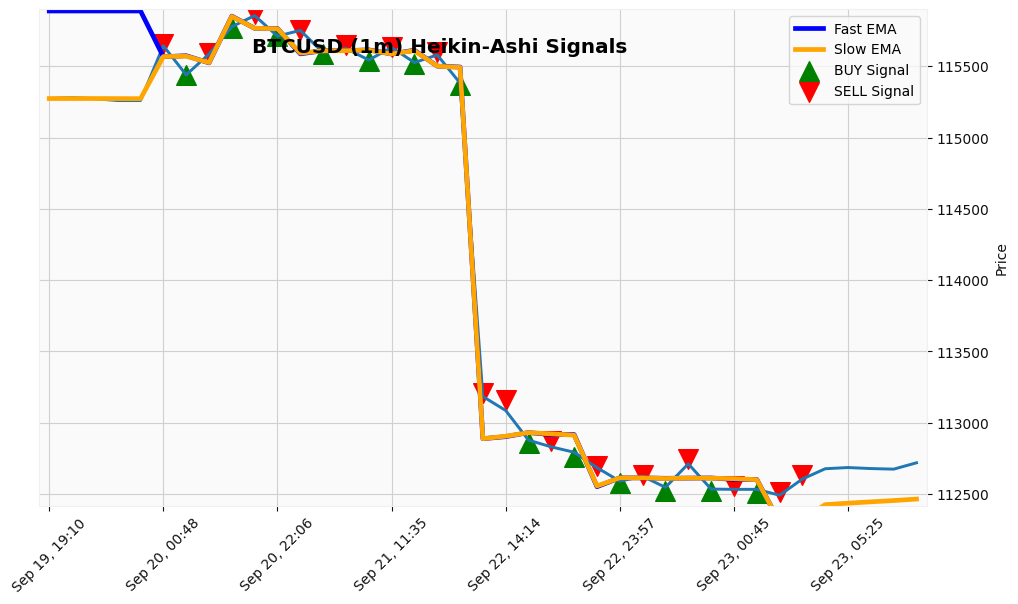

Plot generated for strategy_data\HeikinAshiStrategy_985edfc516\signals.csv


In [158]:
plot_all_signals('./strategy_data')

In [3]:
from lightweight_charts import Chart
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Optional, Tuple

STORAGE_PATH: str = "./strategy_data"


class SignalsData:
    def __init__(self):
        self.df: pd.DataFrame = pd.DataFrame()

    def set(self, df: pd.DataFrame):
        self.df = df

    def get(self) -> pd.DataFrame:
        return self.df

    def get_signals(self, signal_type: str) -> pd.DataFrame:
        return self.df[self.df['Signal'] == signal_type]


g_signals_data: SignalsData = SignalsData()

g_buy_marker_ids = []
g_sell_marker_ids = []


def add_buy_markers(chart: Chart):
    df = chart.candle_data

    if 'signal' in df.columns:
        buy_signals = df[df['signal'] == 'BUY']
    elif 'Signal' in df.columns:
        buy_signals = df[df['Signal'] == 'BUY']
    else:
        buy_signals = pd.DataFrame()

    print(f"Found {len(buy_signals)} BUY signals")

    if not buy_signals.empty:
        clear_buy_markers(chart)
        # Add Buy signals
        for i, (idx, row) in enumerate(buy_signals.iterrows()):
            g_buy_marker_ids.append(
                chart.marker(
                    time=idx,
                    position='below',
                    color='green',
                    shape='arrow_up',
                    text=f"BUY-{i}"
                )
            )


def add_sell_markers(chart: Chart):
    df = chart.candle_data
    if 'signal' in df.columns:
        sell_signals = df[df['signal'] == 'SELL']
    elif 'Signal' in df.columns:
        sell_signals = df[df['Signal'] == 'SELL']
    else:
        sell_signals = pd.DataFrame()

    if not sell_signals.empty:
        clear_sell_markers(chart)
        # Add Sell signals
        for i, (idx, row) in enumerate(sell_signals.iterrows()):
            g_sell_marker_ids.append(
                chart.marker(
                    time=idx,
                    position='above',
                    color='red',
                    shape='arrow_down',
                    text=f"SELL-{i}"
                )
            )


def clear_buy_markers(chart: Chart):
    print(f"Clearing Buy markers: {len(g_buy_marker_ids)}")
    if g_buy_marker_ids:

        for id in g_buy_marker_ids:
            chart.remove_marker(id)

    g_buy_marker_ids.clear()


def clear_sell_markers(chart: Chart):
    print(f"Clearing SELL markers: {len(g_sell_marker_ids)}")
    if g_sell_marker_ids:
        for id in g_sell_marker_ids:
            chart.remove_marker(id)

    g_sell_marker_ids.clear()


def on_buy_toggle(chart: Chart):
    buy_sigs_on: bool = (
        chart.topbar['BUY_SIGNALS_TOGGLE'].value or 'OFF') == 'ON'

    if buy_sigs_on:
        print(f"Adding Buy Markers")
        add_buy_markers(chart)
    else:
        print(f"Clearing Buy Markers")
        clear_buy_markers(chart)


def on_sell_toggle(chart: Chart):
    sell_sigs_on: bool = (
        chart.topbar['SELL_SIGNALS_TOGGLE'].value or 'OFF') == 'ON'

    if sell_sigs_on:
        print(f"Adding Sell Markers")
        add_sell_markers(chart)
    else:
        print(f"Clearing Sell Markers")
        clear_sell_markers(chart)


def on_search(chart: Chart, searched_string: str):
    print(f"on_search: {len(chart.candle_data)}, {searched_string}")

    # new_data = get_bar_data(searched_string, chart.topbar['timeframe'].value)
    # if new_data.empty:
    #     return
    chart.topbar['strategy_name'].set(searched_string)
    # chart.set(new_data)

# Event handler for menu selection


def on_strategy_select(chart: Chart):
    selected_strategy_name = chart.topbar['strategy_select'].value
    print(f"User selected strategy: {selected_strategy_name}")
    ticker, interval, df, ohlc_df = fetch_initial_data(strategy_name=selected_strategy_name)
    
    chart.set(df)  # Set Intial Data

    # Plot EMA lines if they exist
    if 'FastEMA' in df.columns:
        ema_df = pd.DataFrame({
            'time': df.index,  # .strftime('%Y-%m-%d %H:%M:%S'),
            'FastEMA': df['FastEMA']
        }).dropna()
        ema_line = chart.create_line(name='FastEMA', color='blue')
        ema_line.set(ema_df)
    if 'SlowEMA' in df.columns:
        ema_df = pd.DataFrame({
            'time': df.index,  # .strftime('%Y-%m-%d %H:%M:%S'),
            'SlowEMA': df['SlowEMA']
        }).dropna()
        ema_line = chart.create_line(name='SlowEMA', color='orange')
        ema_line.set(ema_df)
    # Fetch and update signals/chart as needed
    # await fetch_api_signals(selected_name) + chart.set(...)


class SignalsFileLoadingException(Exception):
    pass

def fetch_strategies():
    pass

def fetch_initial_data(
    storage_path: Optional[Path]=None, strategy_name: Optional[str]=""
) -> Tuple[Optional[str], Optional[str], Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    try:
        storage = Path(storage_path) if storage_path else Path(STORAGE_PATH)
        signal_files = list(storage.glob(f"{strategy_name}/signals.csv"))
        if not signal_files:
            raise SignalsFileLoadingException(
                f"No signals.csv files found in {storage_path}/{strategy_name}.")

        signal_file_path = signal_files[0]

        print(f"Trying to load: {signal_file_path}")
        df = pd.read_csv(signal_file_path, index_col=0, parse_dates=True)
        df.index.name = 'datetime'
        for col in ['HA_Open', 'HA_High', 'HA_Low', 'HA_Close', 'FastEMA', 'SlowEMA']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        ha_cols_exist = all(c in df.columns for c in [
                            'HA_Open', 'HA_High', 'HA_Low', 'HA_Close'])
        ticker = df['ticker'].iloc[0] if 'ticker' in df.columns else "Unknown"
        interval = df['interval'].iloc[0] if 'interval' in df.columns else "Unknown"

        # Setup OHLCV dataframe for lightweight-charts-python (must be columns: date, open, high, low, close, volume)
        use_cols = ['HA_Open', 'HA_High', 'HA_Low', 'HA_Close'] if ha_cols_exist else [
            'Open', 'High', 'Low', 'Close']
        ohlc_df = pd.DataFrame({
            'date': df.index,
            'open': df[use_cols[0]].values,
            'high': df[use_cols[1]].values,
            'low': df[use_cols[2]].values,
            'close': df[use_cols[3]].values,
        }, index=df.index)

        if 'volume' in df.columns:
            ohlc_df['volume'] = df['volume'].values

        return ticker, interval, df, ohlc_df

    except Exception as e:
        print(f"Error in processing: {e}")
        raise e


async def plot_all_signals_with_lightweight_charts(storage_path):

    try:
        # ticker, interval, df, ohlc_df = fetch_initial_data(
        #     storage_path, "HeikinAshiStrategy_985edfc516")

        # Create the chart
        chart = Chart(
            maximize=False,
            toolbox=True,
            title=f"Signals Charting"
        )
        chart.legend(visible=True)
        # chart.topbar.textbox('strategy_name', 'Search')
        # chart.events.search += on_search

        chart.topbar.textbox('label1', 'Buy Signals')
        chart.topbar.switcher(
            'BUY_SIGNALS_TOGGLE',
            ('ON', 'OFF'),
            default='OFF',
            func=on_buy_toggle
        )
        chart.topbar.textbox('label2', 'Sell Signals')
        chart.topbar.switcher(
            'SELL_SIGNALS_TOGGLE',
            ('ON', 'OFF'),
            default='OFF',
            func=on_sell_toggle
        )

        # Suppose these are your available strategies
        STRATEGY_NAMES = (

            "MACD_Crossover",
            "HeikinAshiStrategy_985edfc516",
            "ATR_Breakout",
            "SupertrendCombo",
        )

        chart.topbar.textbox('label10', 'Strategy Name:')
        # Add a dropdown (menu) to the chart topbar
        chart.topbar.menu(
            'strategy_select',
            STRATEGY_NAMES,
            default=STRATEGY_NAMES[0],
            separator=True,
            func=on_strategy_select
        )


        # chart.show(block=True)
        await chart.show_async()
        print(f"Plot generated")

    except Exception as e:
        print(f"Error in processing: {e}")

In [4]:
await plot_all_signals_with_lightweight_charts(STORAGE_PATH)

User selected strategy: HeikinAshiStrategy_985edfc516
Trying to load: strategy_data\HeikinAshiStrategy_985edfc516\signals.csv
Adding Buy Markers
Found 17 BUY signals
Clearing Buy markers: 0
Adding Sell Markers
Clearing SELL markers: 0
Clearing Buy Markers
Clearing Buy markers: 17
Adding Buy Markers
Found 17 BUY signals
Clearing Buy markers: 0
Plot generated
